In [ ]:
from netCDF4 import Dataset
from glob import glob
import os, sys
import matplotlib.pyplot as plt
import numpy as np

from wrf import getvar, to_np, extract_times, ALL_TIMES, vertcross, CoordPair

is_py = os.path.basename(sys.argv[0]) == 'vert-wind-contour-vid-location.ju.py'

# All ids of the runs we want to plot, separated by series
# {
#     {Location 1}: {
#         'climate_id': {
#             {Climate Loc 1}: Climate Loc ID 1,
#             ...
#         }
#         'start': Cut-off start coords,
#         'end': Cut-off start coords,
#     }
#     ... ,
# }
RUN_DATA = {
    'Tokyo, Japan': {
        'climate_id': {
            'Tokyo': 88,
            'Cairo': 89
        },
        'start': (33, 140),
        'end': (37, 140)
    },
    'Cairo, Egypt': {
        'climate_id': {
            'Tokyo': 87,
            'Cairo': 86
        },
        'start': (28, 31),
        'end': (32, 31)
    }
}

root_dir = '/home/mok/miniguc/'
data_dir = f'tmp/'
image_dir = glob(root_dir + data_dir)[0]
dummy_dataset = Dataset(glob(f'{root_dir}runs/086-*/wrfout*')[0])
z_data = getvar(dummy_dataset, "z", timeidx=0)

if len(glob(image_dir)) == 0:
    os.mkdir(image_dir)

plt.rcParams["font.family"] = "DejaVu Sans Mono"
plt.rcParams["font.size"] = 12

vert_levels = np.linspace(0, 6500, 200)

def get_cross_var(dataset, var, time_idx, start, end):
    start_point = CoordPair(lat = start[0], lon = start[1])
    end_point = CoordPair(lat = end[0], lon = end[1])
    return vertcross(
        var,
        z_data,
        levels=vert_levels,
        wrfin=dataset,
        timeidx=time_idx,
        start_point=start_point,
        end_point=end_point,
        latlon=True,
        meta=True
    )

In [12]:
import math

def generate_subplot(dataset: Dataset, axis, time_idx, start, end):
    u_data = getvar(dataset, "ua", timeidx=time_idx)
    v_data = getvar(dataset, "va", timeidx=time_idx)
    w_data = getvar(dataset, "wa", timeidx=time_idx)
    var_data = getvar(dataset, "T", timeidx=time_idx)
    qrain_data = getvar(dataset, "QRAIN", timeidx=time_idx)
    qvapor_data = getvar(dataset, "QVAPOR", timeidx=time_idx)

    pblh_data = to_np(getvar(dataset, "PBLH", timeidx=time_idx))
    pblh_data = np.repeat(pblh_data[None, :, :], 44, axis=0) # Copy the value to make it 3d

    u_cross = get_cross_var(dataset, u_data, time_idx, start, end)
    v_cross = get_cross_var(dataset, v_data, time_idx, start, end)
    w_cross = get_cross_var(dataset, w_data, time_idx, start, end)
    var_cross = get_cross_var(dataset, var_data, time_idx, start, end) + 300 - 273.15
    qrain_cross = get_cross_var(dataset, qrain_data, time_idx, start, end)
    qvapor_cross = get_cross_var(dataset, qvapor_data, time_idx, start, end)
    pblh_cross = get_cross_var(dataset, pblh_data, time_idx, start, end)

    coord_pairs = to_np(var_cross.coords['xy_loc'])
    coord_pair_labels = [f'{float(pair.latlon_str().split(',')[0]):.1f}' for pair in to_np(coord_pairs)]
    axis.set_xticks(np.arange(coord_pairs.shape[0])[::12])

    mask_x = slice(None, None, 3)
    mask_y = slice(None, None, 10)

    axis.set_xlabel(f'Latitude (Longitude = {start[1]}E)')

    plot_lim = np.linspace(math.floor(-15 + 300 - 273.15), math.ceil(5 + 300 - 273.15), 51) # T
    var_contour = axis.contourf(coord_pair_labels, vert_levels, var_cross, plot_lim, cmap="nipy_spectral", extend="both")

    qrain_plot_lim = np.linspace(1, 9, 5) # QRAIN * 1e5
    qrain_contour = axis.contourf(
        coord_pair_labels,
        vert_levels,
        qrain_cross * 1e5,
        qrain_plot_lim,
        cmap="Blues",
        alpha=0.5,
        extend="max"
    )

    qvapor_plot_lim = np.linspace(0, 3, 10) # QVAPOR * 1e2
    axis.contour(
        coord_pair_labels,
        vert_levels,
        qvapor_cross * 1e2,
        qvapor_plot_lim,
        colors="#283593",
        linewidths=0.7,
        linestyles="dotted",
    )
    axis.plot([], [], color="#283593", linewidth=0.7, linestyle="dotted", label="QVAPOR") # Legend "hack"

    axis.plot(coord_pair_labels, pblh_cross[-1], linestyle="dashdot", color="#5D4037", linewidth=1, label="PBLH")

    axis.quiver(
        coord_pair_labels[mask_x],
        to_np(vert_levels)[mask_y],
        to_np(v_cross)[mask_y, mask_x],
        to_np(w_cross * 50)[mask_y, mask_x],
        color="#444",
        scale=100,
        width=0.003
    )

    return var_contour, qrain_contour


def generate_frame(time_idx, date_time = np.datetime64('1970-01-01')):
    fig, axes = plt.subplots(2, len(RUN_DATA), figsize=(9, 8), sharey="row") # width, height
    fig.tight_layout(pad=4)
    fig.suptitle(f"Vertical Cross-Section Contour of Urban Area on Different Locations\nat {np.datetime_as_string(date_time, unit='s')}", y=1.05)

    for i, (run_name, run_data) in enumerate(RUN_DATA.items()):
        for j, (climate_name, climate_id) in enumerate(run_data['climate_id'].items()):
            dataset = Dataset(glob(f'{root_dir}runs/{climate_id:03}-*/wrfout*')[0])
            var_contour, qrain_contour = generate_subplot(dataset, axes[i][j], time_idx, run_data['start'], run_data['end'])

            # Sample from the middle assuming it's urban
            axes[i][j].set_title(f'{run_name} With\n{climate_name} Climate')

            if i == 0:
                axes[i][j].set_ylabel('Height (m)')

                # Color bar
                fig.subplots_adjust(right=0.77)

                cbar_ax = fig.add_axes((0.925, 0.275, 0.02, 0.5)) # Left, Top (1=top), width, height
                cbar = plt.colorbar(qrain_contour, cax=cbar_ax, shrink=.9, pad=0.1)
                cbar.ax.set_ylabel('Water-Rain Mixing Ratio ($\\times 10^{-5}$)')

                cbar_ax = fig.add_axes((0.8, 0.275, 0.02, 0.5))
                cbar = plt.colorbar(var_contour, cax=cbar_ax, shrink=.9)
                cbar.ax.set_ylabel('Potential Temp. ($^o$C)')

                # Legend
                handles, labels = axes[i][j].get_legend_handles_labels()
                fig.legend(handles, labels, loc=(0.78, 0.06))

    if is_py:
        plt.savefig(image_dir + np.datetime_as_string(date_time, unit='s') + '.png', bbox_inches='tight')

def generate_video():
    times = extract_times(dummy_dataset, timeidx=ALL_TIMES)
    for time_idx, date_time in enumerate(times):
        print(f'Processing {date_time}', end='\r')
        generate_frame(time_idx, date_time)
        plt.close()

Starting visualization for vert-wind-contour


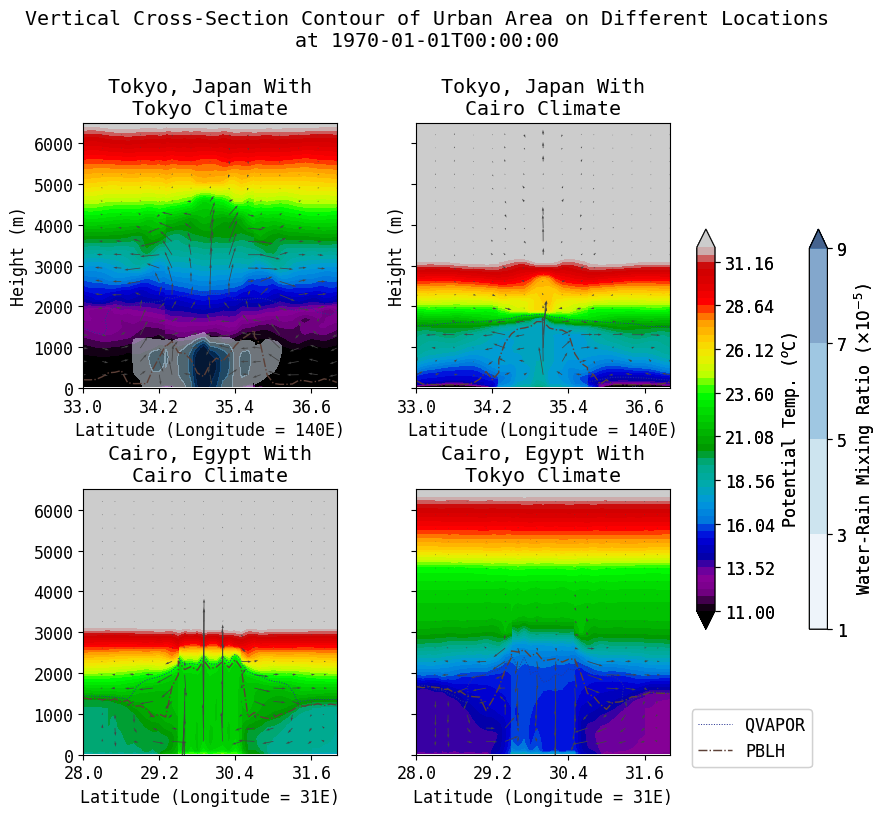

In [13]:
import subprocess

print(f'Starting visualization for vert-wind-contour')

if is_py:
    for image_name in glob(image_dir + '*.png'):
        os.remove(image_name)
    generate_video()
    subprocess.call(['/home/mok/miniguc/scripts/visualize/tmp-generate-video.sh'])
    subprocess.call(['mv', 'out.mp4', root_dir + f'results/LOCATION-vert-contour-{len(glob(root_dir + f'results/LOCATION-vert-contour-*.mp4')) + 1}.mp4'])
    print('Done!!')
else:
    generate_frame(70)
    # plt.savefig('/home/guc/results/test-fig.png', bbox_inches='tight')